# AutoFarm - Anaylsis of Soil Moisture 

For one of my experiments while I quarantined at home during COVID, I planted some basil in a tray and setup some basic sensors and cameras to monitor their growth! I didn't have any end goals in mind. I just wanted to see how my home grown electronics circuits, cheap sensors, and simple webcam would function to monitor the plants.

It turns out that it doesn't take much to monitor the plants. I ended up collected thousands of images and almost a full gigabyte of compressed telemetry using a Raspberry Pi, a cheap webcam, and a few sensors hooked up to a Arduino circuit.

## Soil Moisture

In this notebook, I'm going to explore the soil moisture dataset that was collected and see if we can try to predict the soil moisture utilizing all the other sensor telemetry metrics. To start, we will load the data from S3 utilizing Dask that is distributed acrossed my Kubernetes cluster.

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

client = Client(address="tcp://172.23.0.100:32227")

client.nthreads()

/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/distributed/client.py:1381: VersionMismatchWarning: Mismatched versions found

+---------+-----------------+----------------+----------------+
| Package | Client          | Scheduler      | Workers        |
+---------+-----------------+----------------+----------------+
| msgpack | 1.0.7           | 1.0.5          | 1.0.5          |
| numpy   | 1.26.1          | 1.24.2         | 1.23.5         |
| python  | 3.10.12.final.0 | 3.10.9.final.0 | 3.10.9.final.0 |
| tornado | 6.3.3           | 6.2            | 6.2            |
+---------+-----------------+----------------+----------------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


{'tcp://10.42.1.9:38749': 8,
 'tcp://10.42.2.109:39631': 8,
 'tcp://10.42.3.91:42367': 8,
 'tcp://10.42.5.84:38685': 8}

As we can see, we should have plenty of compute power to process the data!

In [26]:
db_folder = "s3://jam-personal-storage/datasets/auto_farm/experiment_hawaii_2020/csv"

dht11_file = db_folder + "/dht11_full.csv"
ds18b20_file = db_folder + "/ds18b20_full.csv"
soil_file = db_folder + "/soil_full.csv"

dht11 = dd.read_csv(dht11_file)
ds18b20 = dd.read_csv(ds18b20_file)
soil = dd.read_csv(soil_file)

The data files on my S3 bucket are fairly large. Utilizing s3fs, Dask can read the files directly from S3. Pretty slick! As we can see below, the data is stored very simply where we have "sensor" witch is the sensor ID, "timestamp" which is the time the reading was taken, and "value" or "temp" and "humid" as the values of the readings.

In [11]:
print(dht11.columns)
print(ds18b20.columns)
print(soil.columns)

Index(['id', 'sensor', 'temp', 'humid', 'timestamp'], dtype='object')
Index(['id', 'sensor', 'value', 'timestamp'], dtype='object')
Index(['id', 'sensor', 'value', 'timestamp'], dtype='object')


In [12]:
print(dht11.info())
print(dht11.head())
print(dht11.count().compute())

<class 'dask.dataframe.core.DataFrame'>
Columns: 5 entries, id to timestamp
dtypes: object(1), float64(2), int64(2)None
   id  sensor  temp  humid                   timestamp
0   1       1  31.0   67.0  2020-09-29 04:40:36.740803
1   2       1  31.0   67.0  2020-09-29 04:40:36.747705
2   3       1  31.0   67.0  2020-09-29 04:40:38.891525
3   4       1  31.0   67.0  2020-09-29 04:40:38.897305
4   5       1  31.0   67.0  2020-09-29 04:40:41.022430
id           2910330
sensor       2910330
temp         2910330
humid        2910330
timestamp    2910330
dtype: int64


In [13]:
print(ds18b20.info())
print(ds18b20.head())
print(ds18b20.count().compute())

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, id to timestamp
dtypes: object(1), float64(1), int64(2)None
   id  sensor   value                   timestamp
0   1       0  24.375  2020-09-26 06:51:59.705318
1   2       1  24.313  2020-09-26 06:51:59.713459
2   3       0  24.375  2020-09-26 06:51:59.715486
3   4       1  24.375  2020-09-26 06:51:59.717527
4   5       0  24.375  2020-09-26 06:52:01.793895
id           6255018
sensor       6255018
value        6255018
timestamp    6255018
dtype: int64


In [14]:
print(soil.info())
print(soil.head())
print(soil.count().compute())

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, id to timestamp
dtypes: object(1), int64(3)None
   id  sensor  value                   timestamp
0   1       0    658  2020-09-26 06:51:59.652898
1   2       1    675  2020-09-26 06:51:59.661062
2   3       2    695  2020-09-26 06:51:59.662959
3   4       3    636  2020-09-26 06:51:59.664961
4   5       0    655  2020-09-26 06:51:59.666849
id           12510068
sensor       12510068
value        12510068
timestamp    12510068
dtype: int64


In [27]:
# aggregate dht11 data every 10 minutes
dht11['timestamp'] = dd.to_datetime(dht11['timestamp'])
dht11 = dht11.set_index('timestamp')
dht11 = dht11.groupby(['sensor', dht11.index.dt.floor('10T')]).mean()

# aggregate ds18b20 data every 10 minutes
ds18b20['timestamp'] = dd.to_datetime(ds18b20['timestamp'])
ds18b20 = ds18b20.set_index('timestamp')
ds18b20 = ds18b20.groupby(['sensor', ds18b20.index.dt.floor('10T')]).mean()

# aggregate soil data every 10 minutes
soil['timestamp'] = dd.to_datetime(soil['timestamp'])
soil = soil.set_index('timestamp')
soil = soil.groupby(['sensor', soil.index.dt.floor('10T')]).mean()

# rename soil value to soil_moisture
soil = soil.rename(columns={'value': 'soil_moisture'})

# rename ds18b20 value to air_temperature
ds18b20 = ds18b20.rename(columns={'value': 'air_temperature_1'})

# rename dht11 values to air_humidity and air_temperature_2
dht11 = dht11.rename(columns={'humid': 'air_humidity'})
dht11 = dht11.rename(columns={'temp': 'air_temperature_2'})

dht11.compute().to_csv('auto_farm_dht11.csv')
ds18b20.compute().to_csv('auto_farm_ds18b20.csv')
soil.compute().to_csv('auto_farm_soil.csv')

In [2]:
dht11 = pd.read_csv('auto_farm_dht11.csv')
ds18b20 = pd.read_csv('auto_farm_ds18b20.csv')
soil = pd.read_csv('auto_farm_soil.csv')

In [3]:
dht11.describe()

,sensor,id,air_temperature_2,air_humidity
count,5618.0,5.618000e+03,5618.000000,5618.000000
mean,1.0,1.455672e+06,31.389526,65.199776
std,0.0,8.398587e+05,1.495933,1.882391
min,1.0,2.430000e+02,27.000000,58.019380
25%,1.0,7.290114e+05,30.000000,64.000000
50%,1.0,1.456370e+06,31.992293,65.000000
75%,1.0,2.182775e+06,32.424855,66.791365
max,1.0,2.910198e+06,35.059730,69.641221


In [4]:
ds18b20.describe()

,sensor,id,air_temperature_1
count,12074.000000,1.207400e+04,12074.000000
mean,0.500000,3.128550e+06,27.198661
std,0.500021,1.805171e+06,1.520806
min,0.000000,4.160000e+02,23.536868
25%,0.000000,1.566391e+06,26.077695
50%,0.500000,3.129504e+06,27.391184
75%,1.000000,4.691163e+06,28.176677
max,1.000000,6.254720e+06,36.900254


In [5]:
soil.describe()

,sensor,id,soil_moisture
count,24148.000000,2.414800e+04,24148.000000
mean,1.500000,6.257095e+06,492.827642
std,1.118057,3.610267e+06,131.383263
min,0.000000,8.310000e+02,257.821154
25%,0.750000,3.132782e+06,404.438491
50%,1.500000,6.259008e+06,450.343662
75%,2.250000,9.382292e+06,644.760284
max,3.000000,1.250947e+07,718.576108


Since the variability of the timeseries hour to hour probably doesn't change too much, we are resampling the data to 10 minute averages. This will make the data much more manageable and easier to visualize. And, probably easy to fit on my local machine! The processing on Dask took around 6 minutes which was better than I expected and reduced the dataset dramatically.

During the course of the experiment, the temperature could change rapidly at some points simply due to the directionaly of the sun in the floor of my apartment. I'm curious to see if the soil moisture changes in a similar way. Let's take a look at the data!

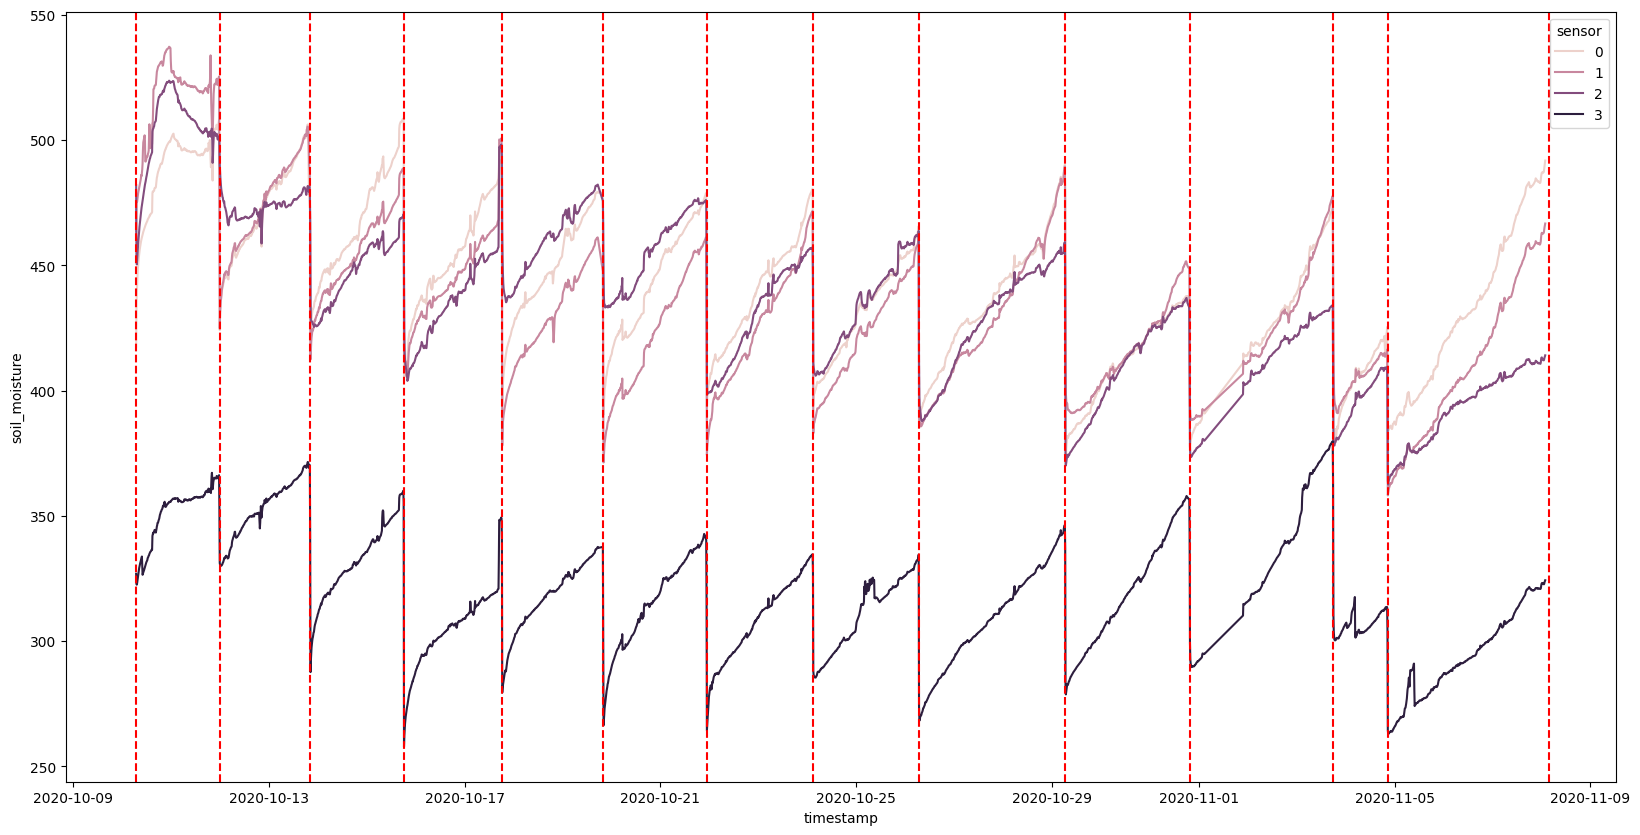

In [6]:
watering = pd.read_csv('soil_water_times.csv')

# from unix timestamp to datetime
watering['timestamp'] = pd.to_datetime(watering['timestamp'] / 1000, unit='s')

# filter from earliest watering time to latest watering time
soil['timestamp'] = pd.to_datetime(soil['timestamp'])
soil = soil[soil['timestamp'] >= watering['timestamp'].min()]

plt.figure(figsize=(20, 10))
sns.lineplot(x='timestamp', y='soil_moisture', data=soil, hue='sensor')
for i, row in watering.iterrows():
    plt.axvline(row['timestamp'], color='red', linestyle='--')

Certainly an interesting first look at the data. We can see that the soil moisture varies from sensor to sensor but they all seem to follor the same pattern over time: They steady go up and then drop all of a sudden. If we overlay the watering times (that I manually recorded), we see that these dips coorespond to them.

We also see that each sensor is not on the same scale. Is this due to where they were positioned? Or is it due to slightly different calibrations? One of the questions we might want to ask is if the moisture evaporation over time is linear or not. Does it start slow and accelerate? Does it start fast and slow down? One thing we certainly need to do is normalize the data so that we can compare the sensors to each other.

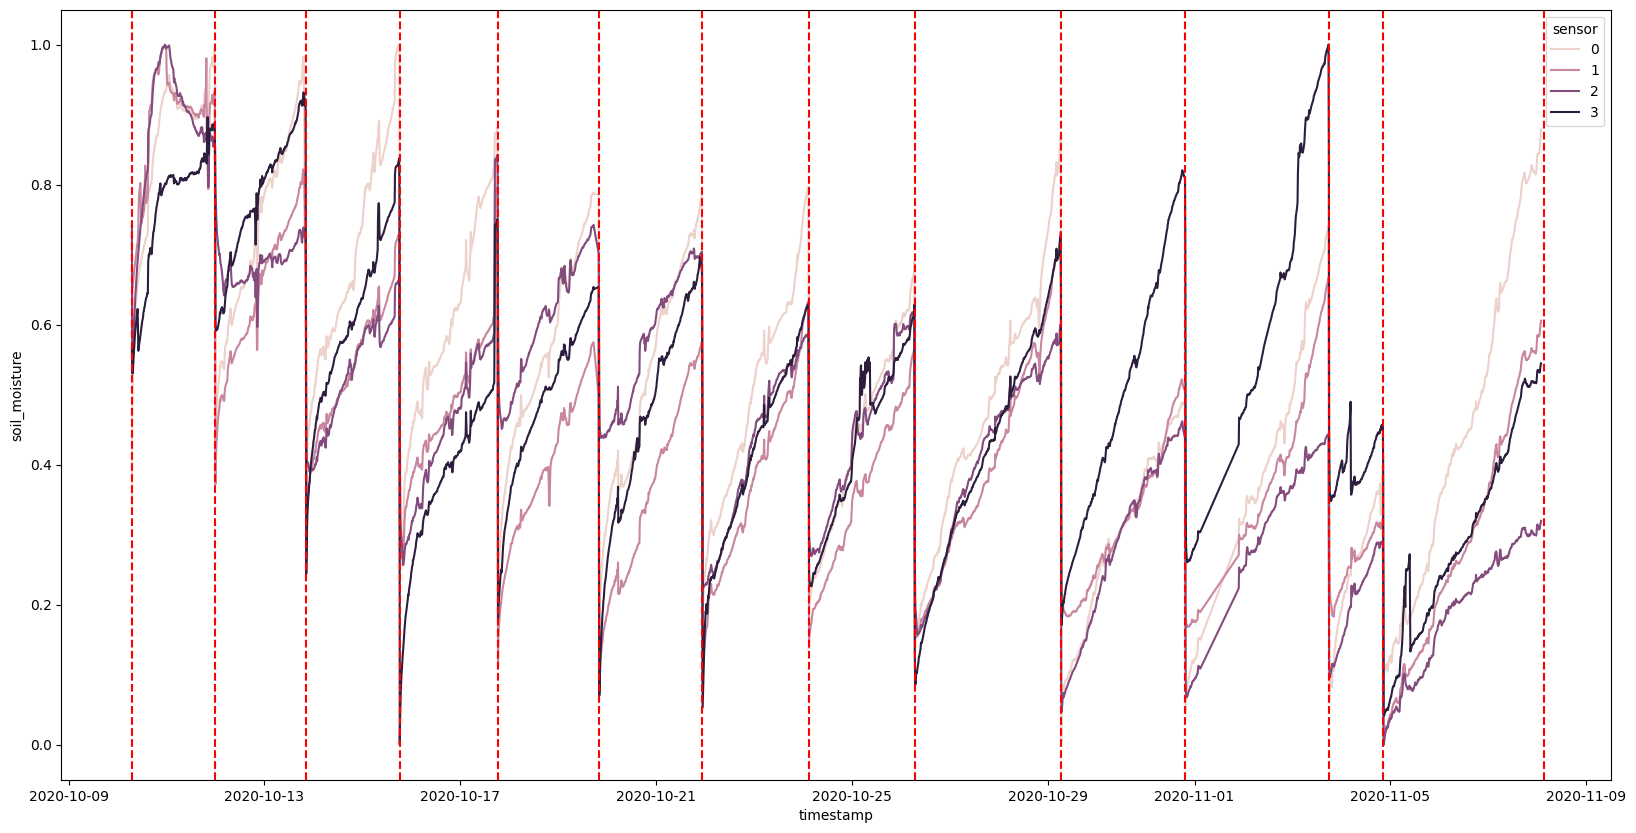

In [8]:
from sklearn.preprocessing import MinMaxScaler

ssoil = soil.copy()

scaler = MinMaxScaler()

dfg = ssoil.groupby('sensor')

for sensor, group in dfg:
    ssoil.loc[ssoil['sensor'] == sensor, 'soil_moisture'] = scaler.fit_transform(group[['soil_moisture']])
    
plt.figure(figsize=(20, 10))
sns.lineplot(x='timestamp', y='soil_moisture', data=ssoil, hue='sensor')
for i, row in watering.iterrows():
    plt.axvline(row['timestamp'], color='red', linestyle='--')

Even when we normalize, not all the sensors are advertising the same scales. Closer! But not perfect. However, they do seem to be following the same rate of evaporation. So let's start by splitting the data apart by the watering times, and try fitting some models to the data.

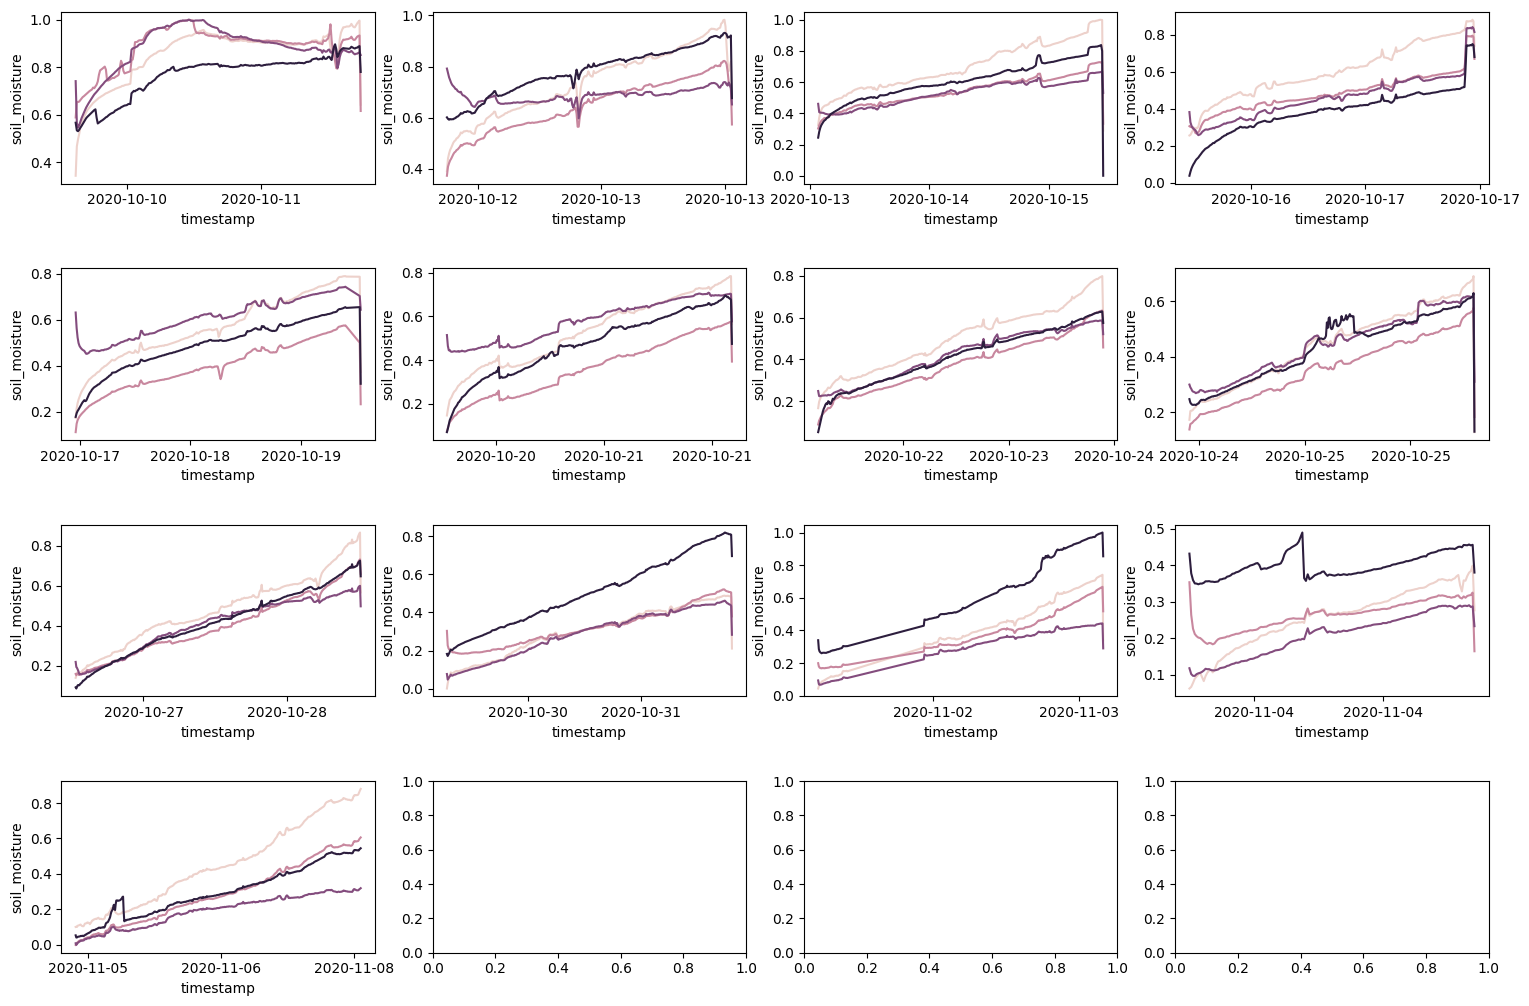

In [21]:
bins = sorted(watering.timestamp.values)

ssoil['watering'] = pd.cut(ssoil['timestamp'], bins)

figure, axises = plt.subplots(4, 4, figsize=(15, 10))
axises = [item for sublist in axises for item in sublist]
figure.tight_layout(h_pad=4)

index = 0
for group in ssoil.groupby('watering'):
    frame = group[1]
    sns.lineplot(x='timestamp', y='soil_moisture', data=frame, hue='sensor', ax=axises[index])
    axises[index].xaxis.set_major_locator(plt.MaxNLocator(3))
    axises[index].get_legend().remove()
    index += 1
plt.show()

Observing each different time between the watering is quite interesting. Most of the time, the rate of change of each sensor appear to be the same. And most appear pretty linear. But, towards the end of the experiment, the rate of change of each sensor seems to behave differently.

This could be due to changing soil chemistry over time, hardware could be corroding, or other unknown variables like the intensity of light, temperature, or humidity. For now, we will ignore these signs and just try to fit a linear model to each sensor.

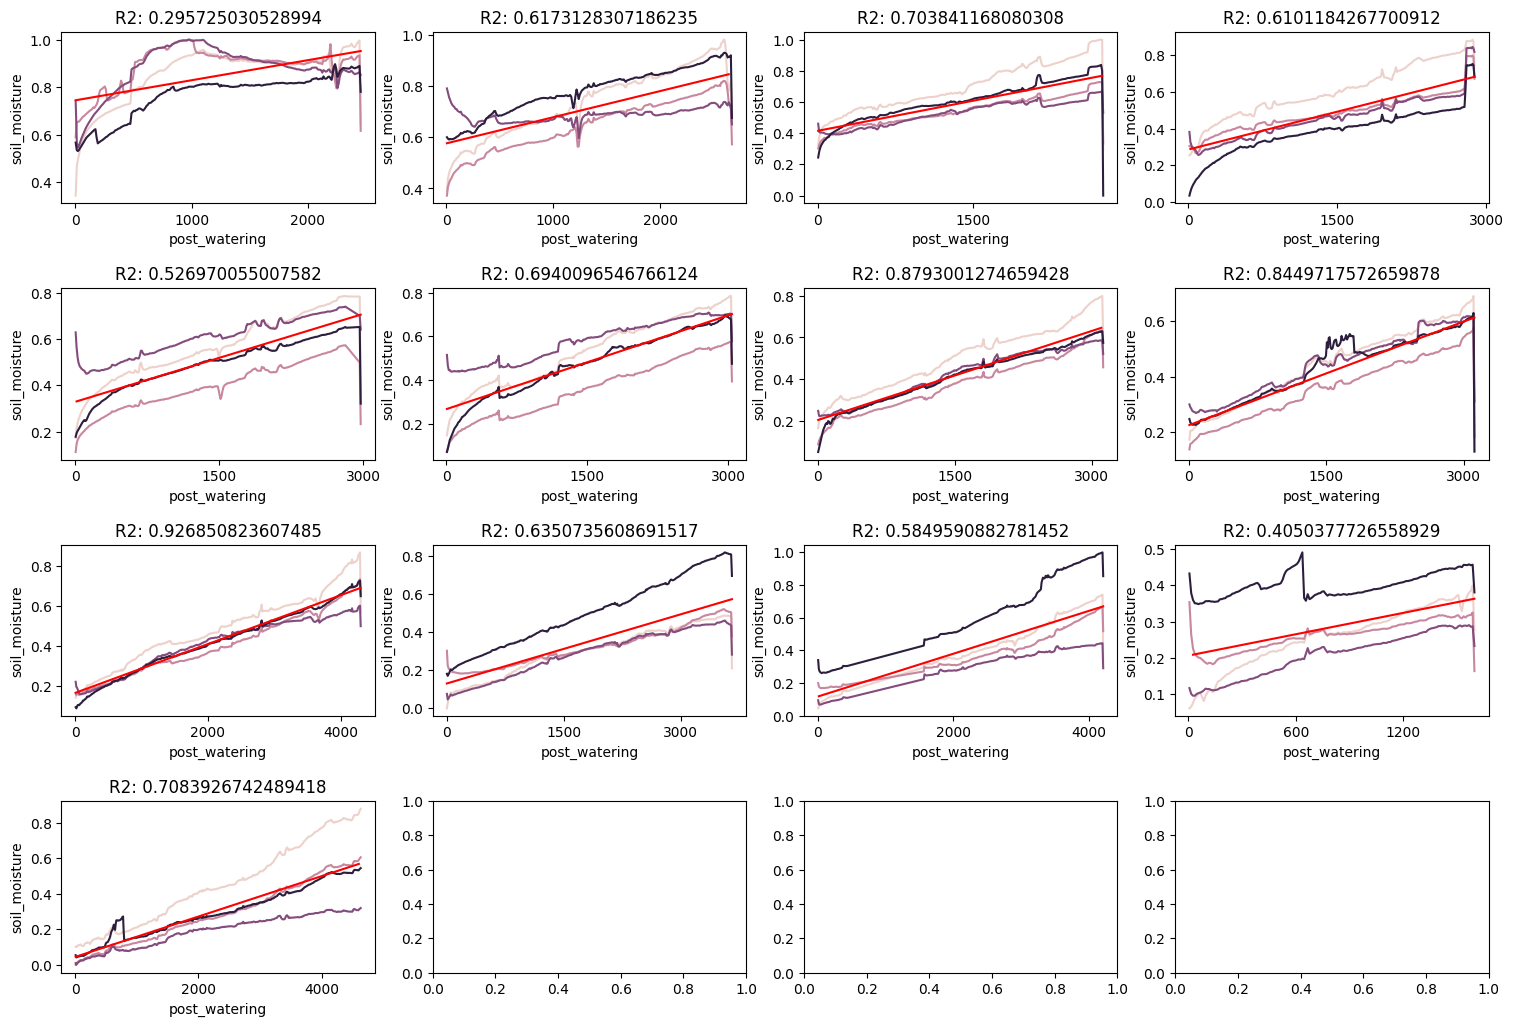

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

figure, axises = plt.subplots(4, 4, figsize=(15, 10))
axises = [item for sublist in axises for item in sublist]
figure.tight_layout(h_pad=4)

index = 0
for group in ssoil.groupby('watering'):
    frame = group[1]
    
    # convert the timestamp to minutes since watering
    frame['post_watering'] = (frame['timestamp'] - group[0].left).dt.total_seconds() / 60
    
    x = frame['post_watering']
    y = frame['soil_moisture']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    x_train = x_train.values.reshape(-1, 1)
    x_test = x_test.values.reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    r2 = r2_score(y_test, y_pred)
    
    axises[index].set_title('R2: ' + str(r2))
    sns.lineplot(x='post_watering', y='soil_moisture', data=frame, hue='sensor', ax=axises[index])
    sns.lineplot(x=x_test.reshape(-1), y=y_pred, ax=axises[index], color='red')
    
    axises[index].xaxis.set_major_locator(plt.MaxNLocator(3))
    axises[index].get_legend().remove()
    index += 1

plt.show()

Ouch! Some of the times our r2 score indicates a very linear relationship. Other times, it's not so good. This would clearly highlight that we need a more complex model or we need more data. Let's try to include the temperature and humidity data to see if that helps predict soil moisture.

In [25]:
# convert to timestamp types
dht11['timestamp'] = pd.to_datetime(dht11['timestamp'])
ds18b20['timestamp'] = pd.to_datetime(ds18b20['timestamp'])

scaler = MinMaxScaler()

# group by the sensor and scale each sensor's values differently
sdht11 = dht11.copy()
for sensor, group in sdht11.groupby('sensor'):
    sdht11.loc[sdht11['sensor'] == sensor, 'air_temperature_2'] = scaler.fit_transform(group[['air_temperature_2']])
    sdht11.loc[sdht11['sensor'] == sensor, 'air_humidity'] = scaler.fit_transform(group[['air_humidity']])
    
sds18b20 = ds18b20.copy()
for sensor, group in sds18b20.groupby('sensor'):
    sds18b20.loc[sds18b20['sensor'] == sensor, 'air_temperature_1'] = scaler.fit_transform(group[['air_temperature_1']])

# filter out data before the first watering time
sdht11 = sdht11[sdht11['timestamp'] >= watering['timestamp'].min()]
sds18b20 = sds18b20[sds18b20['timestamp'] >= watering['timestamp'].min()]

# cut the data by the watering times
bins = sorted(watering.timestamp.values)
sdht11['watering'] = pd.cut(sdht11['timestamp'], bins)
sds18b20['watering'] = pd.cut(sds18b20['timestamp'], bins)

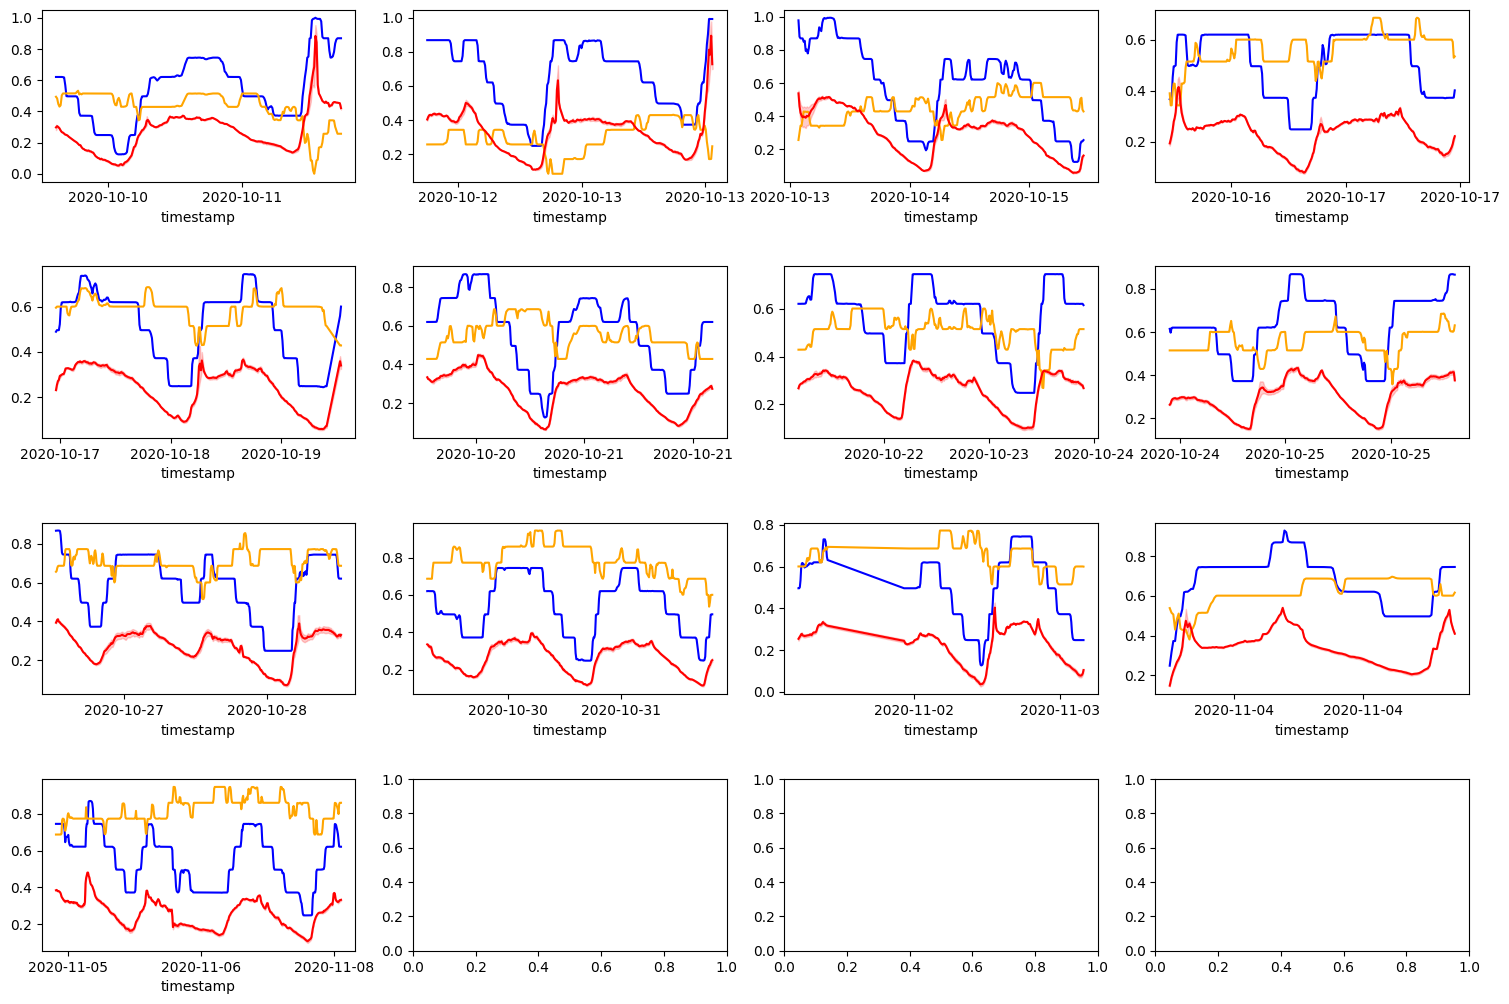

In [32]:
figure, axises = plt.subplots(4, 4, figsize=(15, 10))
axises = [item for sublist in axises for item in sublist]
figure.tight_layout(h_pad=4)

index = 0
for group in sdht11.groupby('watering'):
    frame = group[1]
    sns.lineplot(x='timestamp', y='air_temperature_2', data=frame, ax=axises[index], color='blue')
    sns.lineplot(x='timestamp', y='air_humidity', data=frame, ax=axises[index], color='orange')
    axises[index].xaxis.set_major_locator(plt.MaxNLocator(3))
    axises[index].set_ylabel('')
    index += 1
    
index = 0
for group in sds18b20.groupby('watering'):
    frame = group[1]
    sns.lineplot(x='timestamp', y='air_temperature_1', data=frame, ax=axises[index], color='red')
    axises[index].xaxis.set_major_locator(plt.MaxNLocator(3))
    axises[index].set_ylabel('')
    index += 1

plt.show()

The DS18B20 sensor appears to have a lot higher granularity than the DHT11 sensor. And this is expected. Further, the DS18B20 sensor what the sensor actually mounted next to the plants. Whereas the DHT11 was actually mounted inside the container containing the electronics. It's possible that the temperature is so much higher because of the heat generated by the electronics. However, we want to the humidity from this sensor regardless as it could be a good indicator of humidity outside the container as well. We will experiment with a linear model and see.

In [37]:
# merge dht11 and ds18b20 data
sdf = pd.merge(sdht11, sds18b20, on=['timestamp', 'watering'])
sdf = sdf.rename(columns={'sensor_x': 'dht11_sensor', 'sensor_y': 'ds18b20_sensor'})
sdf = sdf.drop(columns=['id_x', 'id_y'])

# merge soil data
sdf = pd.merge(sdf, ssoil, on=['timestamp', 'watering'])
sdf = sdf.rename(columns={'sensor': 'soil_sensor'})
sdf = sdf.drop(columns=['id'])

# drop any rows where not all sensors have data
sdf = sdf.dropna()

sdf

,dht11_sensor,timestamp,air_temperature_2,air_humidity,watering,ds18b20_sensor,air_temperature_1,soil_sensor,soil_moisture
0,1,2020-10-10 07:00:00,0.620368,0.493506,"(2020-10-10 06:57:00, 2020-10-11 23:53:00]",0,0.314559,0,0.342526
1,1,2020-10-10 07:00:00,0.620368,0.493506,"(2020-10-10 06:57:00, 2020-10-11 23:53:00]",0,0.314559,1,0.588191
2,1,2020-10-10 07:00:00,0.620368,0.493506,"(2020-10-10 06:57:00, 2020-10-11 23:53:00]",0,0.314559,2,0.741284
3,1,2020-10-10 07:00:00,0.620368,0.493506,"(2020-10-10 06:57:00, 2020-10-11 23:53:00]",0,0.314559,3,0.565999
4,1,2020-10-10 07:00:00,0.620368,0.493506,"(2020-10-10 06:57:00, 2020-10-11 23:53:00]",1,0.279822,0,0.342526
...,...,...,...,...,...,...,...,...,...
32155,1,2020-11-08 01:50:00,0.620368,0.858781,"(2020-11-04 20:34:00, 2020-11-08 03:33:00]",0,0.326396,3,0.544824
32156,1,2020-11-08 01:50:00,0.620368,0.858781,"(2020-11-04 20:34:00, 2020-11-08 03:33:00]",1,0.338594,0,0.879349
32157,1,2020-11-08 01:50:00,0.620368,0.858781,"(2020-11-04 20:34:00, 2020-11-08 03:33:00]",1,0.338594,1,0.605907
32158,1,2020-11-08 01:50:00,0.620368,0.858781,"(2020-11-04 20:34:00, 2020-11-08 03:33:00]",1,0.338594,2,0.319791


100%|██████████| 13/13 [03:48<00:00, 17.58s/it]


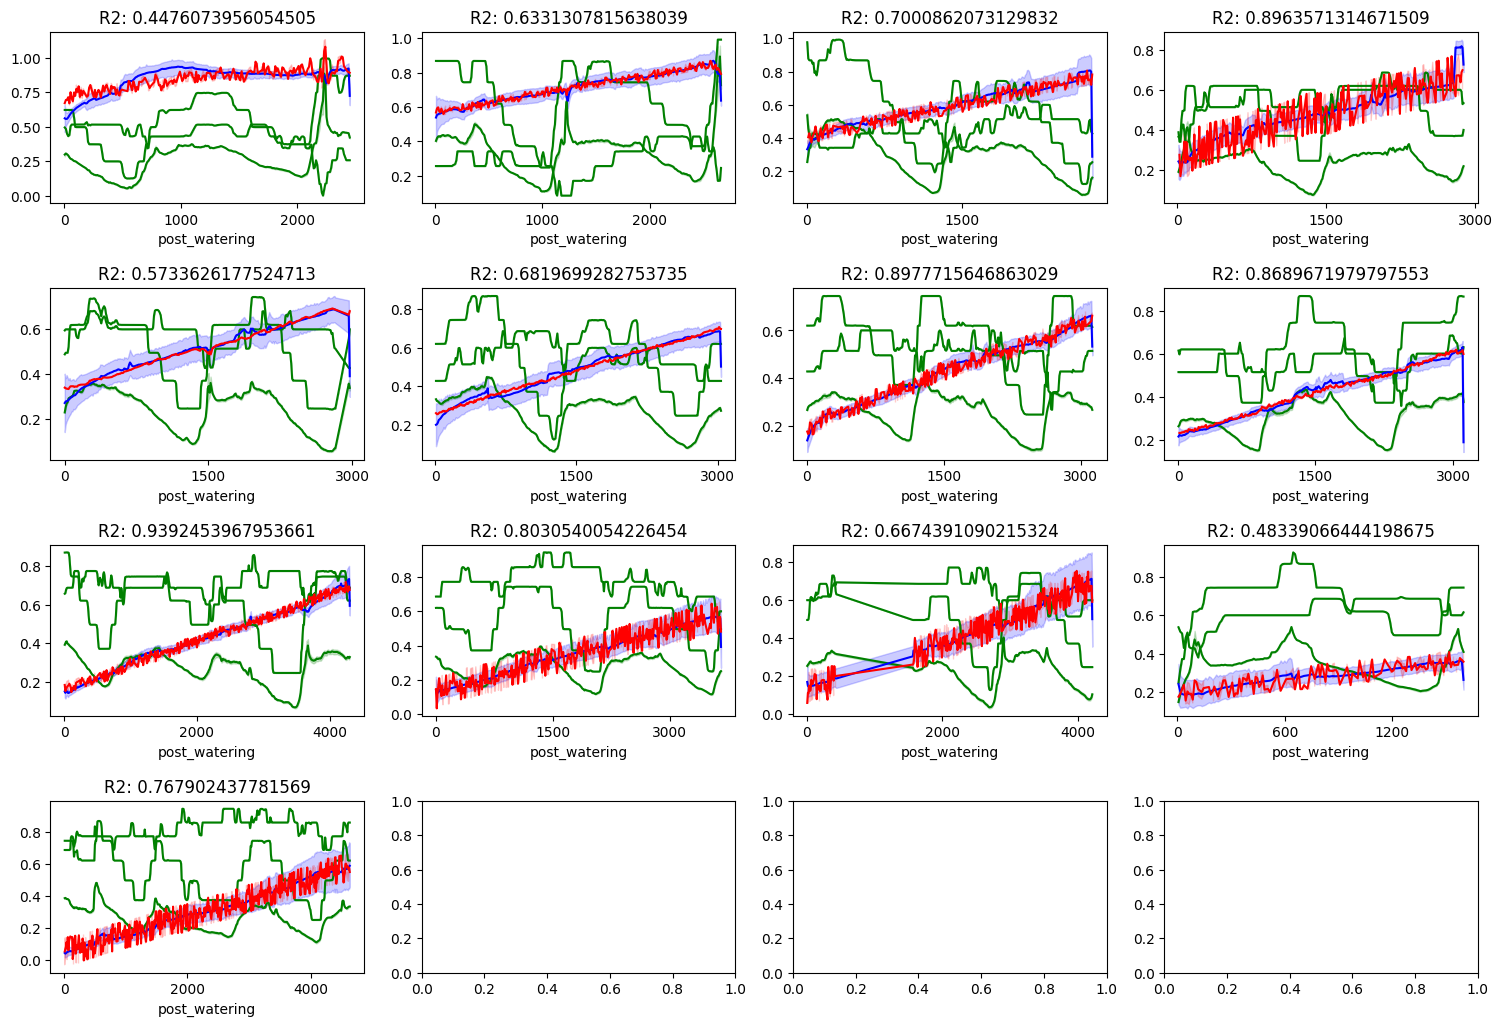

In [54]:
from tqdm import tqdm

figure, axises = plt.subplots(4, 4, figsize=(15, 10))
axises = [item for sublist in axises for item in sublist]
figure.tight_layout(h_pad=4)

sdf_groups = sdf.groupby('watering')

index = 0
for group in tqdm(sdf_groups, total=len(sdf_groups)):
    frame = group[1]
    
    # convert the timestamp to minutes since watering
    frame['post_watering'] = (frame['timestamp'] - group[0].left).dt.total_seconds() / 60
    
    x = frame.drop(columns=['timestamp', 'watering', 'soil_moisture'], axis=1)
    y = frame['soil_moisture']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    model = LinearRegression(n_jobs=-1)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    r2 = r2_score(y_test, y_pred)
    
    # set title
    axises[index].set_title('R2: ' + str(r2))
    sns.lineplot(x='post_watering', y='air_temperature_2', data=frame, ax=axises[index], color='green')
    sns.lineplot(x='post_watering', y='air_humidity', data=frame, ax=axises[index], color='green')
    sns.lineplot(x='post_watering', y='air_temperature_1', data=frame, ax=axises[index], color='green')
    sns.lineplot(x='post_watering', y='soil_moisture', data=frame, ax=axises[index], color='blue')
    sns.lineplot(x=x_test['post_watering'], y=y_pred, ax=axises[index], color='red')
    
    axises[index].xaxis.set_major_locator(plt.MaxNLocator(3))
    axises[index].set_ylabel('')
    index += 1

plt.show()

Now it becomes readily apparent that a linear model is way to simple of a model to describe the data we are seeing. Again, sometimes the metrics are linear in nature leading to a higher R2 score. Other times, it performs very poorly. But with the exploration we have done so far, I'd like to conclude this anaylisis and continue it in another notebook. A couple of keep take aways:

- The soil moisture sensors are not calibrated the same. We need to normalize the data to compare the sensors to each other. Further, we need to understand why they are not calibrated the same. Is it due to the hardware? Or is it due to the soil chemistry?

- Our dataset is massive. And it most likely doesn't need to be. We need to sample our data down significantly using statistical methods. This will make it easier to work with and easier to visualize.

- We need to explore more complex models. Linear models are not going to cut it. We need to explore more complex models like polynomial regression, elastic net, and maybe even neural networks.

- Considering we have two air temperature sensors, and multiple sensors for each value type, we need to understand if we can simplify the dataset using regularization or dimensionality reduction techniques. This may be another form of reducing the size of our dataset while also improving the performance of our models.

- One variable that we are missing that could be very important is the intensity of light. Since we did take timelapse photos, we could certainly extract the brightness of the image and use that as a feature. Furthermore, since the color of the soil changes as it dries out, we could also extract the color of the soil and use that as a feature as well.